In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import zipfile
import os
from PIL import Image
from tqdm import tqdm

In [2]:
# Set local directory for everything
base_dir = "C:/Users/jelly/Desktop/Sem-6/GAN/Experiments/Assignment_3_DCGAN"
zip_path = os.path.join(base_dir, "celeba.zip")  # Path to CelebA zip file
extract_path = base_dir  # Extract in the same directory
dataset_path = os.path.join(base_dir, "img_align_celeba")  # Dataset folder
output_dir = os.path.join(base_dir, "output")  # Output directory for models & images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Extract dataset if not already extracted
if not os.path.exists(dataset_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

In [3]:
# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1,1]
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Check CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_space_size, ngf, n_channel):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_space_size, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, n_channel, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.generator(input)

In [5]:
# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channel, ndf):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(n_channel, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.discriminator(input)

In [6]:
# Initialize models & weights
latent_dim = 100
ngf, ndf, n_channel = 64, 64, 3

In [7]:
netG = Generator(latent_dim, ngf, n_channel).to(device)
netD = Discriminator(n_channel, ndf).to(device)

In [8]:
# Print the architectures
print("Generator Architecture:")
print(netG)

Generator Architecture:
Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=F

In [9]:
print("\nDiscriminator Architecture:")
print(netD)


Discriminator Architecture:
Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid(

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [12]:
# Loss function & Optimizer
criterion = nn.BCELoss().to(device)
lr, beta1 = 0.0002, 0.5
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
# Training Loop (All Outputs Stored Locally)
num_epochs = 3
real_label, fake_label = 1, 0

In [15]:
for epoch in range(num_epochs):
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (real_images, _) in progress_bar:
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        ## Train Discriminator
        netD.zero_grad()
        labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()

        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()

        lossD = lossD_real + lossD_fake
        optimizerD.step()

        ## Train Generator
        netG.zero_grad()
        labels.fill_(real_label)
        output = netD(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()

        # Update tqdm progress bar with losses
        progress_bar.set_postfix({"Loss D": lossD.item(), "Loss G": lossG.item()})

    # Save Sample Images in Local Directory
    save_path = os.path.join(output_dir, f"output_epoch_{epoch+1}.png")
    vutils.save_image(fake_images[:25], save_path, normalize=True)

Epoch 3/3: 100%|██████████| 1583/1583 [02:28<00:00, 10.62it/s, Loss D=0.692, Loss G=1.73] 


In [16]:
# Save Model Checkpoints in Local Directory
torch.save(netG.state_dict(), os.path.join(output_dir, "generator.pth"))
torch.save(netD.state_dict(), os.path.join(output_dir, "discriminator.pth"))

C:\Users\jelly\AppData\Local\Temp\ipykernel_8876\3066976289.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(generator_path, map_location

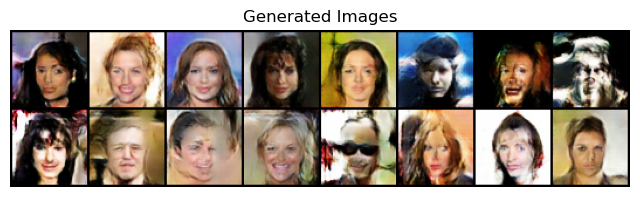

Generated images saved at: C:\Users\jelly\Desktop\Sem-6\GAN\Experiments\Assignment_3_DCGAN\generated\generated_faces.png


In [18]:
import torch
import torchvision.utils as vutils
import os
import matplotlib.pyplot as plt

# Load the trained generator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100  # Ensure this matches what you used in training

# Define paths
output_dir = os.path.join(os.getcwd(), "generated")  # Folder to save generated images
generator_path = os.path.join(os.getcwd(), "output", "generator.pth")  # Path to generator.pth

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Initialize model
netG = Generator(latent_dim, ngf, n_channel).to(device)

# Load model weights
netG.load_state_dict(torch.load(generator_path, map_location=device))  # Keeping as is for full model
netG.eval()  # Set to evaluation mode

# Generate noise
num_samples = 16  # Number of images to generate
noise = torch.randn(num_samples, latent_dim, 1, 1, device=device)

# Generate fake images
with torch.no_grad():  # No gradients needed during inference
    fake_images = netG(noise)

# Save generated images in the "generated" folder
save_path = os.path.join(output_dir, "generated_faces.png")
vutils.save_image(fake_images, save_path, normalize=True)

# Move to CPU before displaying
fake_images_cpu = fake_images.cpu()

# Display generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(vutils.make_grid(fake_images_cpu, padding=2, normalize=True).permute(1, 2, 0))
plt.show()

print(f"Generated images saved at: {save_path}")

### Code to fine tune saved model further on same dataset

In [20]:
# Define paths
dataset_path = os.path.join(os.getcwd(), "C:/Users/jelly/Desktop/Sem-6/GAN/Experiments/Assignment_3_DCGAN/img_align_celeba")
output_dir = os.path.join(os.getcwd(), "output")
os.makedirs(output_dir, exist_ok=True)

In [21]:
generator_path = os.path.join(output_dir, "generator.pth")
discriminator_path = os.path.join(output_dir, "discriminator.pth")

In [22]:
# Define training parameters
batch_size = 128
image_size = 64
num_epochs = 10  # Fine-tune for 10 more epochs
latent_dim = 100
lr = 0.0002
beta1 = 0.5

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [24]:
# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [25]:
# Define Generator and Discriminator (use your previous model definitions)
class Generator(nn.Module):
    def __init__(self, latent_dim, ngf, nc):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator(x)

In [26]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

In [27]:
# Initialize models
netG = Generator(latent_dim, ngf=64, nc=3).to(device)
netD = Discriminator(nc=3, ndf=64).to(device)

In [28]:
# Load pre-trained weights
netG.load_state_dict(torch.load(generator_path, map_location=device))
netD.load_state_dict(torch.load(discriminator_path, map_location=device))

C:\Users\jelly\AppData\Local\Temp\ipykernel_8876\1164981063.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(generator_path, map_location=

<All keys matched successfully>

In [29]:
# Set to training mode
netG.train()
netD.train()

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [30]:
# Loss function
criterion = nn.BCELoss().to(device)

# Optimizers (reinitialize or load previous optimizer states if saved)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [31]:
# Labels for real and fake data
real_label = 1.0
fake_label = 0.0

In [33]:
# Fine-tuning loop
print("Starting Fine-Tuning...")

for epoch in range(num_epochs):
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (real_images, _) in progress_bar:
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        ## Train Discriminator
        netD.zero_grad()
        labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()

        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()

        lossD = lossD_real + lossD_fake
        optimizerD.step()

        ## Train Generator
        netG.zero_grad()
        labels.fill_(real_label)
        output = netD(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()

        # Update progress bar
        progress_bar.set_postfix(Loss_D=lossD.item(), Loss_G=lossG.item())

    # Save generated images for each epoch
    save_path = os.path.join(output_dir, f"fine_tuned_epoch_{epoch+1}.png")
    vutils.save_image(fake_images[:25], save_path, normalize=True)

    # Save models after every epoch
    torch.save(netG.state_dict(), generator_path)
    torch.save(netD.state_dict(), discriminator_path)

print("Fine-tuning complete! Models and generated images are saved.")

Starting Fine-Tuning...


Epoch 5/10:   1%|          | 18/1583 [00:03<05:20,  4.88it/s, Loss_D=0.543, Loss_G=2.06]


KeyboardInterrupt: 

C:\Users\jelly\AppData\Local\Temp\ipykernel_8876\3066976289.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(generator_path, map_location

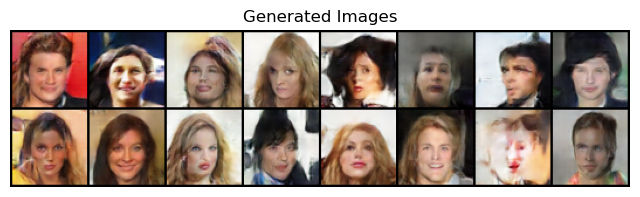

Generated images saved at: C:\Users\jelly\Desktop\Sem-6\GAN\Experiments\Assignment_3_DCGAN\generated\generated_faces.png


In [34]:
import torch
import torchvision.utils as vutils
import os
import matplotlib.pyplot as plt

# Load the trained generator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100  # Ensure this matches what you used in training

# Define paths
output_dir = os.path.join(os.getcwd(), "generated")  # Folder to save generated images
generator_path = os.path.join(os.getcwd(), "output", "generator.pth")  # Path to generator.pth

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Initialize model
netG = Generator(latent_dim, ngf, n_channel).to(device)

# Load model weights
netG.load_state_dict(torch.load(generator_path, map_location=device))  # Keeping as is for full model
netG.eval()  # Set to evaluation mode

# Generate noise
num_samples = 16  # Number of images to generate
noise = torch.randn(num_samples, latent_dim, 1, 1, device=device)

# Generate fake images
with torch.no_grad():  # No gradients needed during inference
    fake_images = netG(noise)

# Save generated images in the "generated" folder
save_path = os.path.join(output_dir, "generated_faces.png")
vutils.save_image(fake_images, save_path, normalize=True)

# Move to CPU before displaying
fake_images_cpu = fake_images.cpu()

# Display generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(vutils.make_grid(fake_images_cpu, padding=2, normalize=True).permute(1, 2, 0))
plt.show()

print(f"Generated images saved at: {save_path}")